<a href="https://colab.research.google.com/github/yonk069/Portfoli0/blob/main/NHC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt


Files found: 8
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_1.csv
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_2.csv
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_3.csv
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_4.csv
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_5.csv
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_6.csv
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_7.csv
/content/drive/MyDrive/aadhaar_project/aadhaar_master_FINAL_part_8.csv


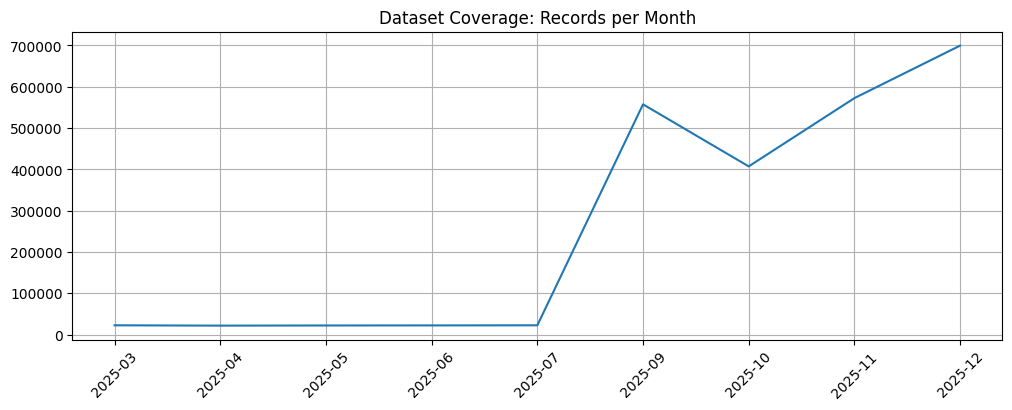

Merged dataset shape: (2346664, 20)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,enrol_total,demo_total,bio_total,updates_total,updates_per_enrol,demo_share,bio_share,updates_z,month
0,2025-03-01,Andaman & Nicobar Islands,Andamans,744101.0,0.0,0.0,0.0,0.0,0.0,16.0,193.0,0.0,0.0,209.0,209.0,NaN,0.000000,1.000000,4.315400,2025-03
1,2025-03-01,Andaman and Nicobar Islands,Nicobar,744301.0,0.0,0.0,0.0,16.0,180.0,101.0,48.0,0.0,196.0,149.0,345.0,NaN,0.568116,0.431884,8.625001,2025-03
2,2025-03-01,Andaman and Nicobar Islands,Nicobar,744302.0,0.0,0.0,0.0,0.0,0.0,15.0,12.0,0.0,0.0,27.0,27.0,NaN,0.000000,1.000000,2.603284,2025-03
3,2025-03-01,Andaman and Nicobar Islands,Nicobar,744303.0,0.0,0.0,0.0,0.0,0.0,46.0,27.0,0.0,0.0,73.0,73.0,NaN,0.000000,1.000000,2.477380,2025-03
4,2025-03-01,Andaman and Nicobar Islands,Nicobar,744304.0,0.0,0.0,0.0,0.0,0.0,16.0,14.0,0.0,0.0,30.0,30.0,NaN,0.000000,1.000000,1.384760,2025-03


In [6]:


DATA_PATH = "/content/drive/MyDrive/aadhaar_project"
files = sorted(glob.glob(f"{DATA_PATH}/aadhaar_master_FINAL_part_*.csv"))

print("Files found:", len(files))
print(*files, sep="\n")

df = pd.concat([pd.read_csv(f, low_memory=False) for f in files], ignore_index=True)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

df["month"] = df["date"].dt.to_period("M").astype(str)

monthly_rows = df.groupby("month").size().reset_index(name="rows")

plt.figure(figsize=(12,4))
plt.plot(monthly_rows["month"], monthly_rows["rows"])
plt.xticks(rotation=45)
plt.title("Dataset Coverage: Records per Month")
plt.grid(True)
plt.show()

print("Merged dataset shape:", df.shape)
df.head()


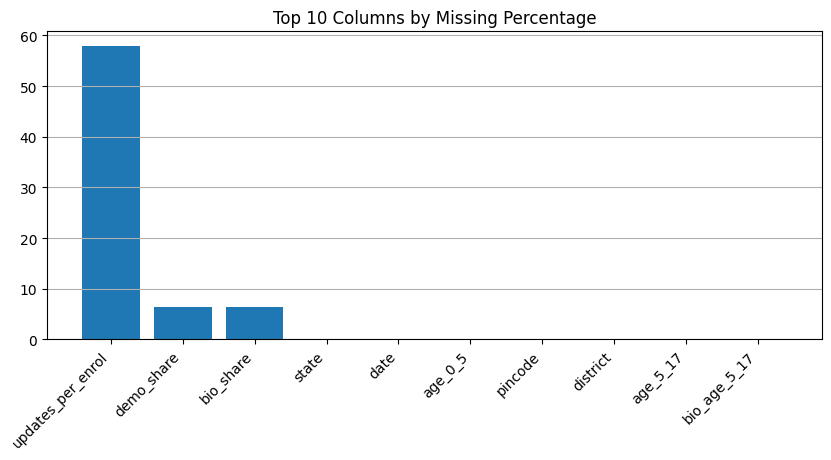

,0
updates_per_enrol,57.906884
demo_share,6.436073
bio_share,6.436073
state,0.000000
date,0.000000
age_0_5,0.000000
pincode,0.000000
district,0.000000
age_5_17,0.000000
bio_age_5_17,0.000000


In [14]:
# fill numeric columns safely
num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

# missing % per column
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,4))
plt.bar(missing_pct.index, missing_pct.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Columns by Missing Percentage")
plt.grid(True, axis="y")
plt.show()

missing_pct


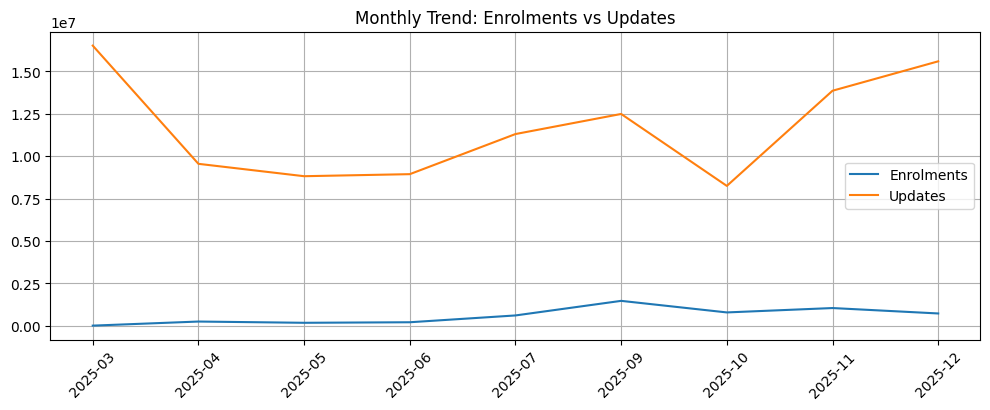

In [15]:
df["enrol_total"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]
df["demo_total"] = df["demo_age_5_17"] + df["demo_age_17_"]
df["bio_total"]  = df["bio_age_5_17"] + df["bio_age_17_"]
df["updates_total"] = df["demo_total"] + df["bio_total"]

df["updates_per_enrol"] = df["updates_total"] / df["enrol_total"].replace(0, np.nan)
df["demo_share"] = df["demo_total"] / df["updates_total"].replace(0, np.nan)
df["bio_share"]  = df["bio_total"] / df["updates_total"].replace(0, np.nan)

monthly_kpi = df.groupby("month")[["enrol_total","updates_total"]].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(monthly_kpi["month"], monthly_kpi["enrol_total"], label="Enrolments")
plt.plot(monthly_kpi["month"], monthly_kpi["updates_total"], label="Updates")
plt.xticks(rotation=45)
plt.title("Monthly Trend: Enrolments vs Updates")
plt.legend()
plt.grid(True)
plt.show()


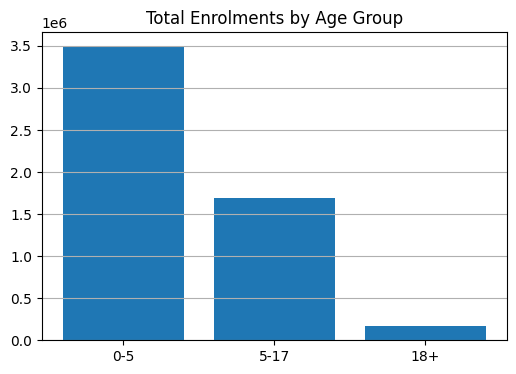

{'0-5': np.float64(3486582.0),
 '5-17': np.float64(1693641.0),
 '18+': np.float64(166508.0)}

In [27]:
age_totals = {
    "0-5": df["age_0_5"].sum(),
    "5-17": df["age_5_17"].sum(),
    "18+": df["age_18_greater"].sum()
}

plt.figure(figsize=(6,4))
plt.bar(age_totals.keys(), age_totals.values())
plt.title("Total Enrolments by Age Group")
plt.grid(True, axis="y")
plt.show()

age_totals

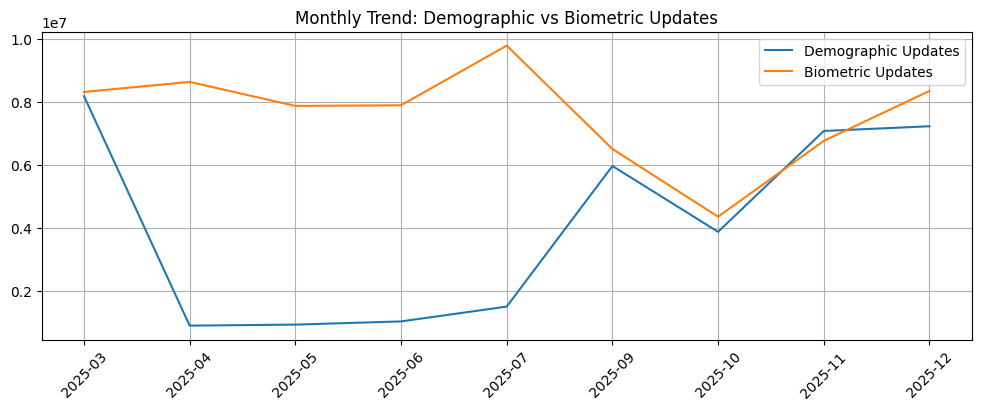

In [17]:
monthly_updates = df.groupby("month")[["demo_total","bio_total"]].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(monthly_updates["month"], monthly_updates["demo_total"], label="Demographic Updates")
plt.plot(monthly_updates["month"], monthly_updates["bio_total"], label="Biometric Updates")
plt.xticks(rotation=45)
plt.title("Monthly Trend: Demographic vs Biometric Updates")
plt.legend()
plt.grid(True)
plt.show()


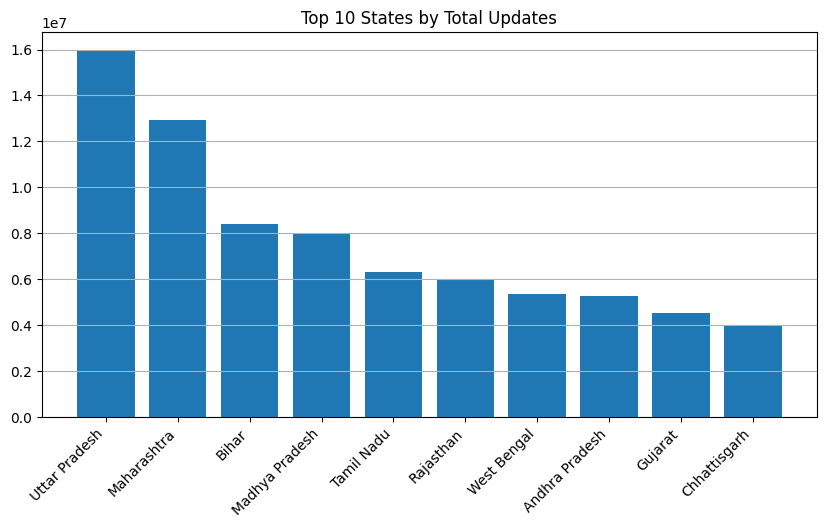

,updates_total
state,
Uttar Pradesh,15970488.0
Maharashtra,12925702.0
Bihar,8417812.0
Madhya Pradesh,7944561.0
Tamil Nadu,6330336.0
Rajasthan,6011315.0
West Bengal,5350957.0
Andhra Pradesh,5252826.0
Gujarat,4506003.0


In [19]:
state_rank = df.groupby("state")["updates_total"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(state_rank.index, state_rank.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 States by Total Updates")
plt.grid(True, axis="y")
plt.show()

state_rank


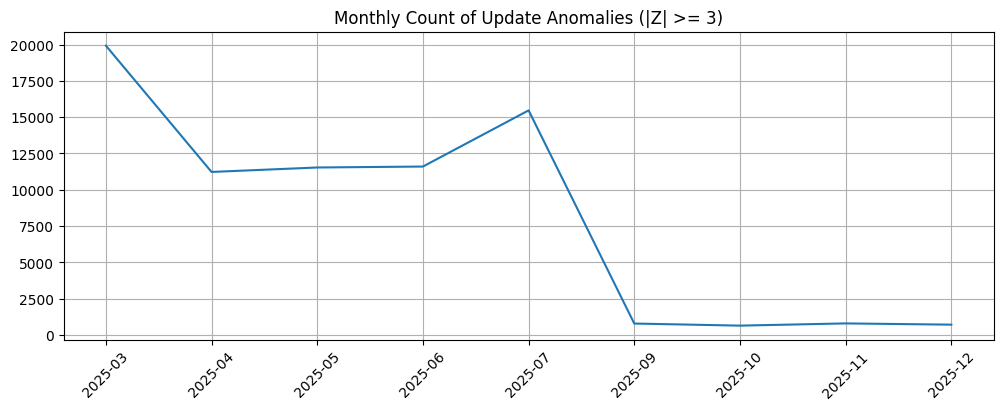

,date,state,district,pincode,updates_total,updates_z
69788,2025-06-01,Chhattisgarh,Balrampur,497225.0,11210.0,9.978726
14282,2025-03-01,Rajasthan,Baran,325221.0,8943.0,9.945621
14270,2025-03-01,Rajasthan,Banswara,327801.0,10423.0,9.848062
2563,2025-03-01,Assam,South Salmara Mankachar,783128.0,1045.0,9.818730
69957,2025-06-01,Chhattisgarh,Kondagaon,494226.0,22031.0,9.811181
14260,2025-03-01,Rajasthan,Banswara,327027.0,3783.0,9.783993
14321,2025-03-01,Rajasthan,Bharatpur,321202.0,1885.0,9.783088
19993,2025-03-01,Uttar Pradesh,Maharajganj,273164.0,6279.0,9.735478
14709,2025-03-01,Rajasthan,Jhalawar,326039.0,4536.0,9.728344
14261,2025-03-01,Rajasthan,Banswara,327031.0,6325.0,9.708854


In [20]:
def zscore(series):
    std = series.std(ddof=0)
    if std == 0:
        return series * 0
    return (series - series.mean()) / std

df["updates_z"] = df.groupby(["state","district","pincode"])["updates_total"].transform(zscore)
df["anomaly_flag"] = (df["updates_z"].abs() >= 3).astype(int)

anomaly_monthly = df.groupby("month")["anomaly_flag"].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(anomaly_monthly["month"], anomaly_monthly["anomaly_flag"])
plt.xticks(rotation=45)
plt.title("Monthly Count of Update Anomalies (|Z| >= 3)")
plt.grid(True)
plt.show()

# show top spikes
top_spikes = df[df["updates_total"] > 0].nlargest(10, "updates_z")
top_spikes[["date","state","district","pincode","updates_total","updates_z"]]


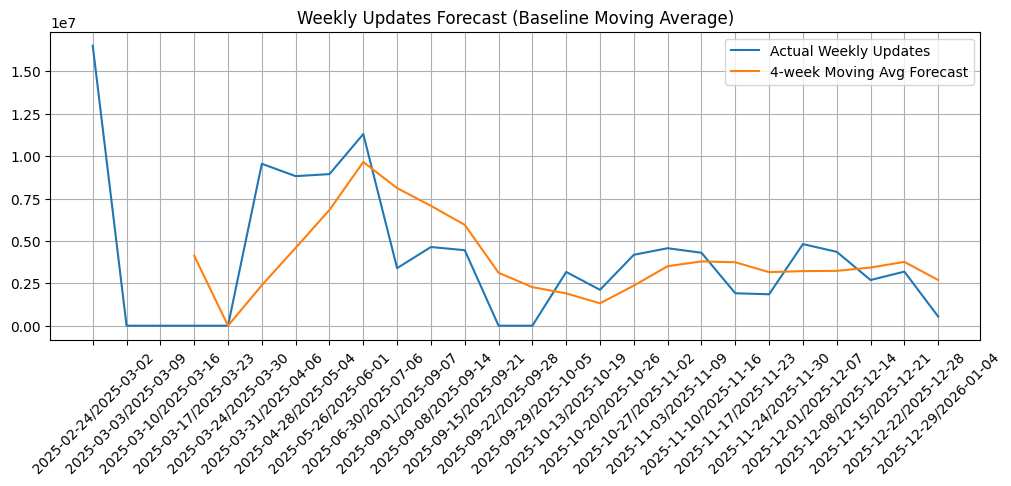

In [21]:
df["week"] = df["date"].dt.to_period("W").astype(str)

weekly = df.groupby("week")["updates_total"].sum().reset_index()
weekly["ma4"] = weekly["updates_total"].rolling(4).mean()

plt.figure(figsize=(12,4))
plt.plot(weekly["week"], weekly["updates_total"], label="Actual Weekly Updates")
plt.plot(weekly["week"], weekly["ma4"], label="4-week Moving Avg Forecast")
plt.xticks(rotation=45)
plt.title("Weekly Updates Forecast (Baseline Moving Average)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
OUT_PATH = "/content/drive/MyDrive/aadhaar_project/outputs"
os.makedirs(OUT_PATH, exist_ok=True)

df.to_csv(f"{OUT_PATH}/aadhaar_clean_kpis_anomalies.csv", index=False)
weekly.to_csv(f"{OUT_PATH}/weekly_updates_forecast_ready.csv", index=False)

print("Saved outputs to:", OUT_PATH)


Saved outputs to: /content/drive/MyDrive/aadhaar_project/outputs


In [23]:
import pandas as pd
import numpy as np

df["week"] = df["date"].dt.to_period("W").astype(str)

weekly_state = (
    df.groupby(["week","state"])[["updates_total","demo_total","bio_total","enrol_total"]]
    .sum()
    .reset_index()
)

# Convert week into a sortable datetime
weekly_state["week_start"] = pd.to_datetime(weekly_state["week"].str.split("/").str[0])
weekly_state = weekly_state.sort_values(["state","week_start"])

weekly_state.head()


,week,state,updates_total,demo_total,bio_total,enrol_total,week_start
252,2025-09-01/2025-09-07,100000,0.0,0.0,0.0,4.0,2025-09-01
307,2025-09-08/2025-09-14,100000,0.0,0.0,0.0,6.0,2025-09-08
363,2025-09-15/2025-09-21,100000,0.0,0.0,0.0,2.0,2025-09-15
557,2025-10-20/2025-10-26,100000,0.0,0.0,0.0,1.0,2025-10-20
717,2025-11-10/2025-11-16,100000,0.0,0.0,0.0,5.0,2025-11-10


In [24]:
for lag in [1,2,3,4]:
    weekly_state[f"lag_{lag}"] = weekly_state.groupby("state")["updates_total"].shift(lag)

weekly_state["rolling_4"] = (
    weekly_state.groupby("state")["updates_total"]
    .shift(1)
    .rolling(4)
    .mean()
    .reset_index(level=0, drop=True)
)

model_df = weekly_state.dropna().copy()
model_df.head()


,week,state,updates_total,demo_total,bio_total,enrol_total,week_start,lag_1,lag_2,lag_3,lag_4,rolling_4
717,2025-11-10/2025-11-16,100000,0.0,0.0,0.0,5.0,2025-11-10,0.0,0.0,0.0,0.0,4.50
988,2025-12-15/2025-12-21,100000,1.0,1.0,0.0,161.0,2025-12-15,0.0,0.0,0.0,0.0,56663.25
1045,2025-12-22/2025-12-28,100000,1.0,1.0,0.0,17.0,2025-12-22,1.0,0.0,0.0,0.0,6.25
1104,2025-12-29/2026-01-04,100000,0.0,0.0,0.0,12.0,2025-12-29,1.0,1.0,0.0,0.0,3.25
208,2025-06-30/2025-07-06,Andaman & Nicobar Islands,259.0,0.0,259.0,0.0,2025-06-30,140.0,180.0,184.0,209.0,17.25


In [25]:
cutoff = model_df["week_start"].quantile(0.85)

train = model_df[model_df["week_start"] <= cutoff]
test  = model_df[model_df["week_start"] > cutoff]

features = [f"lag_{i}" for i in [1,2,3,4]] + ["rolling_4"]

X_train = train[features]
y_train = train["updates_total"]

X_test = test[features]
y_test = test["updates_total"]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (650, 5)
Test shape: (77, 5)


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Import numpy for sqrt

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred) # Calculate MSE first
rmse = np.sqrt(mse) # Then take the square root for RMSE

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 32374.09870129871
RMSE: 61841.38807924103


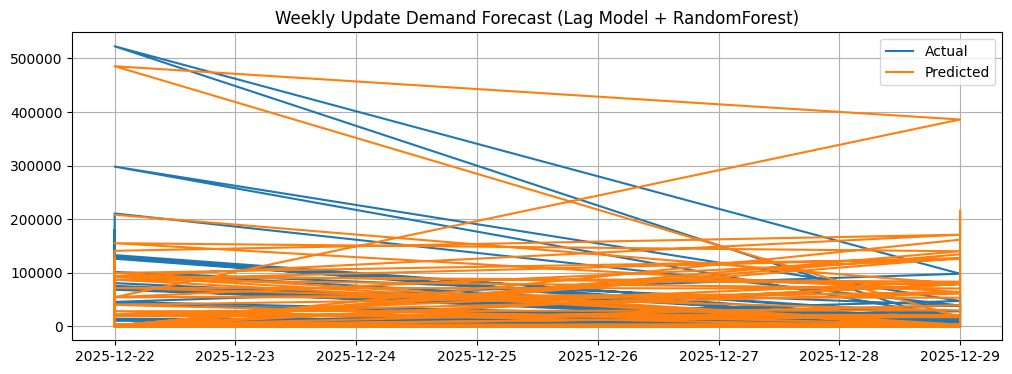

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(test["week_start"], y_test.values, label="Actual")
plt.plot(test["week_start"], pred, label="Predicted")
plt.title("Weekly Update Demand Forecast (Lag Model + RandomForest)")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
top_states = (
    weekly_state.groupby("state")["updates_total"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

top_states


,updates_total
state,
Uttar Pradesh,15970488.0
Maharashtra,12925702.0
Bihar,8417812.0
Madhya Pradesh,7944561.0
Tamil Nadu,6330336.0


STATE: Uttar Pradesh
MAE: 277434.5577777778


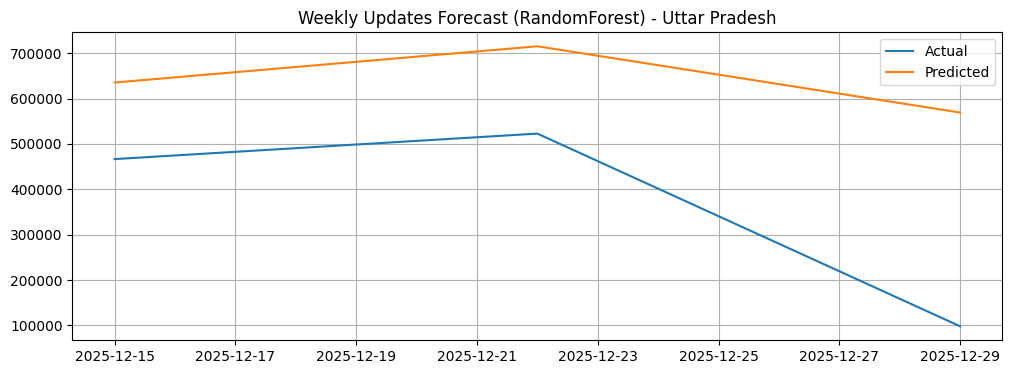

In [31]:
STATE = top_states.index[0]   # change index[0] to index[1], index[2] etc

one = model_df[model_df["state"] == STATE].copy()

cutoff = one["week_start"].quantile(0.85)
train_one = one[one["week_start"] <= cutoff]
test_one  = one[one["week_start"] > cutoff]

features = [f"lag_{i}" for i in [1,2,3,4]] + ["rolling_4"]

X_train = train_one[features]
y_train = train_one["updates_total"]

X_test = test_one[features]
y_test = test_one["updates_total"]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

m = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
m.fit(X_train, y_train)

pred = m.predict(X_test)

print("STATE:", STATE)
print("MAE:", mean_absolute_error(y_test, pred))

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(test_one["week_start"], y_test.values, label="Actual")
plt.plot(test_one["week_start"], pred, label="Predicted")
plt.title(f"Weekly Updates Forecast (RandomForest) - {STATE}")
plt.legend()
plt.grid(True)
plt.show()
